# Tutorial for Real NVP

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow.contrib.eager as tfe # For eager mode
#tfe.enable_eager_execution()

%matplotlib inline
tf.set_random_seed(0)
sess = tf.InteractiveSession()
tfd = tf.contrib.distributions
tfb = tfd.bijectors

/Users/tachi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
# Setting
DTYPE = tf.float32
NP_DTYPE = np.float32
MODEL = 'NVP' # Which Normalizing Flow to use. 'NVP' or 'MAF' or 'IAF'
USE_BATCHNORM = True

In [3]:
# Generate and sample a complex distribution
batch_size=512
x2_dist = tfd.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample(batch_size)
x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                scale=tf.ones(batch_size, dtype=tf.float32))
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)

# Generate and sample a source distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], dtype=tf.float32))
base_samples = base_dist.sample(batch_size)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlo

In [4]:
## Real NVP
def net(x, out_size):
    return tf.contrib.layers.stack(x, tf.contrib.layers.fully_connected, [512, 512, out_size])

# Affine Coupling layer for Real-NVP
class NVPCoupling(tfb.Bijector):
    """NVP affine coupling layer for 2D units.
    """

    def __init__(self, D, d, layer_id=0, validate_args=False, name="NVPCoupling"):
        """
        Args:
          d: First d units are pass-thru units.
        """
        # first d numbers decide scaling/shift factor for remaining D-d numbers.
        super(NVPCoupling, self).__init__(
             forward_min_event_ndims=1, 
            validate_args=validate_args, 
            name=name
        )
        self.D, self.d = D, d
        self.id = layer_id
        # create variables here
        tmp = tf.placeholder(dtype=DTYPE, shape=[1, self.d])
        self.s(tmp)
        self.t(tmp)

    def s(self, xd):
        with tf.variable_scope('s%d' % self.id, reuse=tf.AUTO_REUSE):
            return net(xd, self.D - self.d) # Adjust the number of dimensions for the hadamard product

    def t(self, xd):
        with tf.variable_scope('t%d' % self.id, reuse=tf.AUTO_REUSE):
            return net(xd, self.D - self.d) # Adjust the number of dimensions for the hadamard product

    def _forward(self, x):
        xd, xD = x[:, :self.d], x[:, self.d:]
        yD = xD * tf.exp(self.s(xd)) + self.t(xd)  # [batch, D-d]
        return tf.concat([xd, yD], axis=1)

    def _inverse(self, y):
        yd, yD = y[:, :self.d], y[:, self.d:]
        xD = (yD - self.t(yd)) * tf.exp(-self.s(yd))
        return tf.concat([yd, xD], axis=1)

    def _forward_log_det_jacobian(self, x):
        event_dims = tf.cast(self._forward_event_shape_tensor(x), dtype=tf.int32)
        xd = x[:, :self.d]
        return tf.reduce_sum(self.s(xd), axis=1)
    
    def _inverse_log_det_jacobian(self, y):
        return -self._forward_log_det_jacobian(y)

***
### NICE (volume preserving)
$$
\rm{Forward\ addictive\ coupling\ layer}\ \it{f_{xz}}\rm{:}\\
\mathbf{z}_{\rm 1} = \mathbf{x}_{\rm 1}\\
\mathbf{z}_{\rm 2} = \mathbf{x}_{\rm 2} + T(\mathbf{x}_{\rm 1};\theta)\\
$$
$$
\rm{Inverse\ addictive\ coupling\ layer}\ \it{f_{zx}}\rm{:}\\
\mathbf{x}_{\rm 1} = \mathbf{z}_{\rm 1}\\
\mathbf{x}_{\rm 2} = \mathbf{z}_{\rm 2} - T(\mathbf{z}_{\rm 1};\theta)\\
$$
$$
\rm{Forward\ Jacobian\ determinant}\ \it{R_{xz}}\rm{:}\ 1
$$
$$
\rm{Inverse\ Jacobian\ determinant}\ \it{R_{zx}}\rm{:}\ 1
$$
***
### Real NVP (non volume preserving)
$$
\rm{Forward\ affine\ coupling\ layer}\ \it{f_{xz}}\rm{:}\\ 
\mathbf{z}_{\rm 1} = \mathbf{x}_{\rm 1}\\
\mathbf{z}_{\rm 2} = \mathbf{x}_{\rm 2}\odot \exp(-\ S(\mathbf{x}_{\rm 1};\theta)) + T(\mathbf{x}_{\rm 1};\theta)\\
$$
$$
\rm{Inverse\ affine\ coupling\ layer}\ \it{f_{zx}}\rm{:}\\
\mathbf{x}_{\rm 1} = \mathbf{z}_{\rm 1}\\
\mathbf{x}_{\rm 2} = \mathbf{z}_{\rm 2}\odot \exp(-\ S(\mathbf{z}_{\rm 1};\theta)) - T(\mathbf{z}_{\rm 1};\theta)\\
$$
$$
\rm{Forward\ Jacobian\ determinant}\ \it{R_{xz}}\rm{:}\ 
\mathrm{e}^{\sum_{\it i} S(\mathbf{x}_{1};\theta)_{\it i}}
$$
$$
\rm{Inverse\ Jacobian\ determinant}\ \it{R_{zx}}\rm{:}\ 
\mathrm{e}^{-\sum_{\it i}S(\mathbf{z}_{1};\theta)_{\it i}}
$$
***

In [5]:
# BatchNorm Bijector
class BatchNorm(tfb.Bijector):
    def __init__(self, eps=1e-5, decay=0.95, validate_args=False, name="batch_norm"):
        super(BatchNorm, self).__init__(
             forward_min_event_ndims=1, validate_args=validate_args, name=name)
        self._vars_created = False
        self.eps = eps
        self.decay = decay

    def _create_vars(self, x):
        n = x.get_shape().as_list()[1]
        with tf.variable_scope(self.name):
            self.beta = tf.get_variable('beta', [1, n], dtype=DTYPE)
            self.gamma = tf.get_variable('gamma', [1, n], dtype=DTYPE)
            self.train_m = tf.get_variable('mean', [1, n], dtype=DTYPE, trainable=False)
            self.train_v = tf.get_variable('var', [1, n], dtype=DTYPE, 
                initializer=tf.ones_initializer, trainable=False)
        self._vars_created = True

    def _forward(self, u):
        if not self._vars_created:
            self._create_vars(u)
        return (u - self.beta) * tf.exp(-self.gamma) * tf.sqrt(self.train_v + self.eps) + self.train_m

    def _inverse(self, x):
        # Eq 22. Called during training of a normalizing flow.
        if not self._vars_created:
            self._create_vars(x)
        # statistics of current minibatch
        m, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        # update train statistics via exponential moving average
        update_train_m = tf.assign_sub(
            self.train_m, self.decay * (self.train_m - m))
        update_train_v = tf.assign_sub(
            self.train_v, self.decay * (self.train_v - v))
        # normalize using current minibatch statistics, followed by BN scale and shift
        with tf.control_dependencies([update_train_m, update_train_v]):
            return (x - m) * 1. / tf.sqrt(v + self.eps) * tf.exp(self.gamma) + self.beta

    def _inverse_log_det_jacobian(self, x):
        # at training time, the log_det_jacobian is computed from statistics of the
        # current minibatch.
        if not self._vars_created:
            self._create_vars(x)
        _, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        abs_log_det_J_inv = tf.reduce_sum(self.gamma - .5 * tf.log(v + self.eps))
        return abs_log_det_J_inv

In [6]:
# Construct the flow
bijectors = []
num_layers = 5
nd = 2
sepdim = 1
perm_list = [1, 0]

for i in range(num_layers):
    if MODEL == 'NVP':
        bijectors.append(NVPCoupling(D=nd, d=sepdim, layer_id=i))
    elif MODEL == 'MAF':
        bijectors.append(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512])))
    elif MODEL == 'IAF':
        bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512]))))
    if USE_BATCHNORM and i % 2 == 0:
        # BatchNorm helps to stabilize deep normalizing flows, esp. Real-NVP
        bijectors.append(BatchNorm(name='batch_norm%d' % i))
    bijectors.append(tfb.Permute(permutation=perm_list))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


In [7]:
# Visualize the flow (before optimization)
x = base_dist.sample(batch_size)
samples = [x]
names = [base_dist.name]

for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [8]:
sess.run(tf.global_variables_initializer())

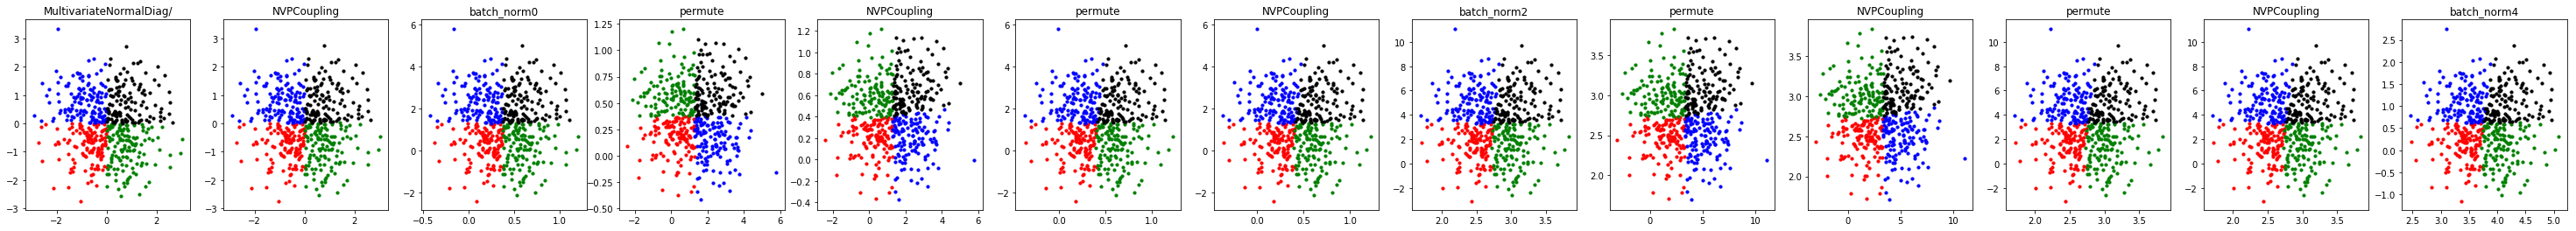

In [9]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]

for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

In [10]:
# Optimize the flow
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)
sess.run(tf.global_variables_initializer())
NUM_STEPS = int(500)
global_step = []
np_losses = []

for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 1000 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e4) == 0:
        print(i, np_loss)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
Use tf.cast instead.
0 8.044947


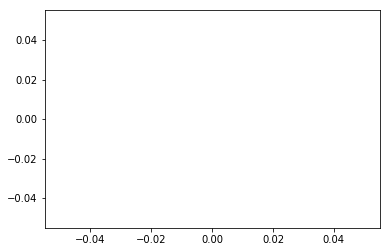

In [11]:
# Plot the loss function
start = 10
plt.plot(np_losses[start:])

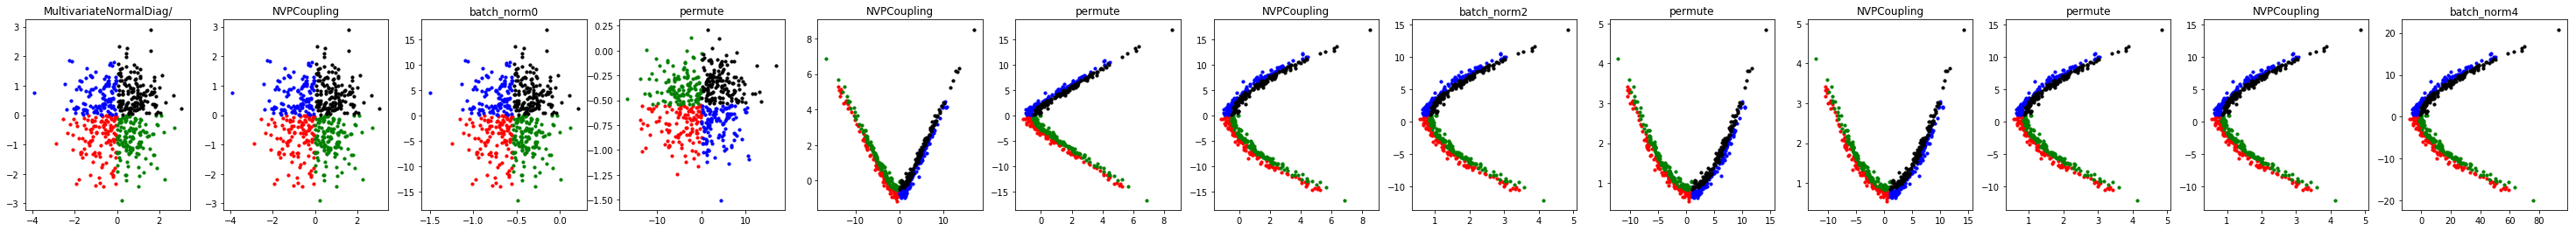

In [12]:
# Visualize the normalizing flow
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]

for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

<IPython.core.display.Javascript object>


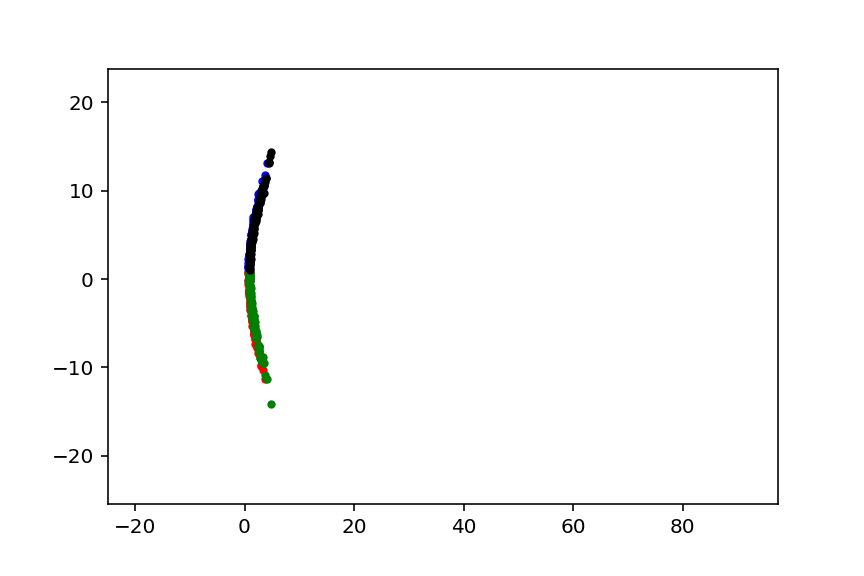

In [18]:
# Animation
%matplotlib nbagg
# We can only use this magic comment on Jupyter Notebook so far (15/07/2019).
import matplotlib.animation as animation
results = sess.run(samples)
X0 = results[0]
images = []
fig = plt.figure()

for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    image1 = plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    image2 = plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    image3 = plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    image4 = plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    images.append([image1] +[image2] +[image3] + [image4])
    
ani = animation.ArtistAnimation(fig, images, interval=1000)
ani.save('outputs/anim.gif', writer="imagemagick")
plt.show()

In [14]:
# Understanding the flow by Tensorboard
summary_writer = tf.summary.FileWriter('data', graph=sess.graph)
tf.summary.scalar('summary', samples)

<tf.Tensor 'summary:0' shape=() dtype=string>

In [15]:
# Visualize the flow (Generation)
test = base_dist.sample(10000)
test_samples = [test]
test_names = [base_dist.name]

for bijector in reversed(dist.bijector.bijectors):
    test = bijector.forward(test)
    test_samples.append(test)
    test_names.append(bijector.name)

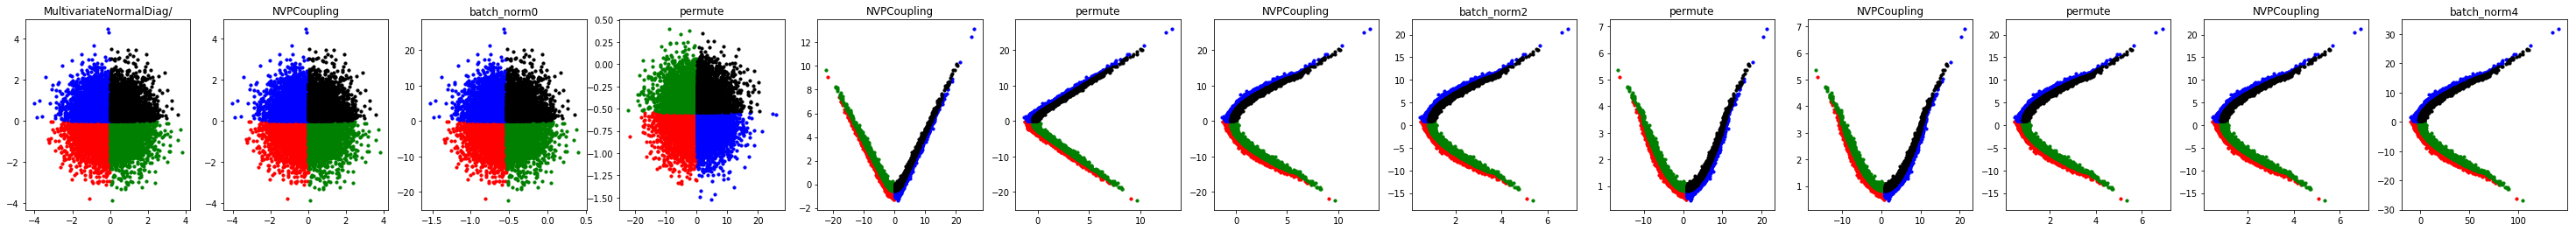

In [16]:
%matplotlib inline
results = sess.run(test_samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]

for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])